### Questão 8

Qual fração de alunos de Mestrado/Doutorado (do total em cada programa) defendeu em 2017?

###### Definir DataFrame da Tabela de Discentes

In [134]:
import pandas as pd

csv_file = "discentes.csv"
discentes_raw = pd.read_csv(csv_file)
discentes_data = discentes_raw
discentes_data.rename(columns = {'nível': 'nivel'}, inplace=True)
# discentes_data.head()

###### Definir DataFrame da Tabela de Trabalhos

In [135]:
csv_file = "trabalhos.csv"
trabalhos_raw = pd.read_csv(csv_file)
trabalhos_data = trabalhos_raw
# trabalhos_data.head()

###### Definir colunas em comum entre as tabelas

In [136]:
common_columns = []
for column_name in discentes_data.columns: # Para cada coluna na tabela de discentes
    if(column_name in trabalhos_data): # Se a coluna existir na tabela de trabalhos
        common_columns.append(column_name) # Marcar como coluna em comum
common_columns

['ies', 'orientador', 'programa']

###### Reorganizar tabelas (retirar colunas desnecessárias para a questão)

In [137]:
# Utilizando variaveis auxiliares para mexer com as tabelas
aux_discentes_data = discentes_data.copy()
aux_trabalhos_data = trabalhos_data.copy()

# Manter somente as colunas necessárias nas tabelas
to_drop_in_discentes = []
for column_name in aux_discentes_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in common_columns and column_name != 'nivel'): # Selecionar colunas desncessárias
        to_drop_in_discentes.append(column_name)

aux_discentes_data = aux_discentes_data.drop(to_drop_in_discentes, 1) # Retirar colunas desnecessárias

to_drop_in_trabalhos = []
for column_name in aux_trabalhos_data.columns: # Para cada coluna da tabela de trabalhos
    if(column_name not in common_columns and column_name != 'data_defesa'): # Selecionar colunas desncessárias
        to_drop_in_trabalhos.append(column_name)

aux_trabalhos_data = aux_trabalhos_data.drop(to_drop_in_trabalhos, 1)  # Retirar colunas desnecessárias

###### Preparação de dados das tabelas para OUTER JOIN

In [138]:
# Dicionários para guardar strings definitivas (chaves) e as strings equivalentes (valores)
# Ex: PUC-Rio: [PUC-Rio, PUC - RIO, puc rj, puc rio]
possible_ies = {}
possible_programas = {}
possible_orientadores = {}

# Verificar se as strings sao equivalentes
def match_strings(str1, str2, error):
    diffs = 0
    aux_str1 = str1.replace(" ", "")
    aux_str2 = str2.replace(" ", "")
    for a, b in zip(aux_str1, aux_str2):
        if a != b:
            diffs += 1
            if(diffs > error):
                return 0
    return 1

# Tratar strings: tenta  verificar se a string pertence à algum grupo e adicioná-la à ele, ou criar um novo grupo para ela
def treat_string(c, column):
    if(not isinstance(c, str)):
        return c
    else:
        if(column == 'ies'):
            possible_group = possible_ies
            error = 10
        elif(column == 'programa'):
            possible_group = possible_programas
            error = 2
        elif(column == 'orientador'):
            possible_group = possible_orientadores
            error = 2

        # Para cada grupo, verifica se a string stual pertence aquele grupo (igual à uma string daquele grupo)
        for key in possible_group:
            if(c in possible_group[key]):
                return key
                break
            else:
                # Para cada string do grupo, verifica se a string atual é semelhante
                for possible_name in possible_group[key]:
                    if(match_strings(c, possible_name, error)):
                        possible_group[key].append(c);
                        return key
                        break
        # Se a string não se assemelha à nenhum grupo, cria um grupo novo para ela
        possible_group[c] = [c]
        return c
    
# Aplica o tratamento de strings às tabelas auxiliares
for column in aux_discentes_data:
    if(column in common_columns):
        aux_discentes_data[column] = aux_discentes_data[column].apply(treat_string, args=([column]))

for column in aux_trabalhos_data:
    if(column in common_columns):
        aux_trabalhos_data[column] = aux_trabalhos_data[column].apply(treat_string, args=([column]))

In [139]:
# aux_discentes_data.head()

In [156]:
# aux_trabalhos_data.head()

###### OUTER JOIN das tabelas auxiliares

In [151]:
# Mergeando as tabelas

merged_discentes_trabalhos = pd.merge(aux_discentes_data, aux_trabalhos_data, how='outer', on=common_columns)
# merged_discentes_trabalhos.head()

###### Definir dados necessários (total de alunos de mestrado/doutorado por programa e quais deles defenderam em 2017)

In [167]:
import array

# Definir quais são todos os diferentes programas
programas = []

for index, row in merged_discentes_trabalhos.iterrows():
    programa = row['programa']
    if(programa not in programas and isinstance(programa, str)):
        programas.append(programa)

# Definir o total de alunos de mestrado/doutorado em cada programa e quantos desses alunos defenderam em 2017
mestrado_por_programa = array.array('i', (0 for i in range(0, len(programas))))
doutorado_por_programa = array.array('i', (0 for i in range(0, len(programas))))
total_mestrado = array.array('i', (0 for i in range(0, len(programas))))
total_doutorado = array.array('i', (0 for i in range(0, len(programas))))

for index, row in merged_discentes_trabalhos.iterrows():
    programa = row['programa']
    nivel = row['nivel']
    defesa = row['data_defesa']
    if(isinstance(programa, str)):
        index = programas.index(programa)
        if(nivel == 'Mestrado'):
            total_mestrado[index] += 1 # Aluno de Mestrado nesse programa
            if(isinstance(defesa, str)):
                if(defesa[-4:] == '2017'):  # Aluno de Mestrado nesse programa que defendeu em 2017
                    mestrado_por_programa[index] += 1
        elif(nivel == 'Doutorado'):
            total_doutorado[index] += 1 # Aluno de Doutorado nesse programa
            if(isinstance(defesa, str)):
                if(defesa[-4:] == '2017'):  # Aluno de Doutorado nesse programa que defendeu em 2017
                    doutorado_por_programa[index] += 1

# Definir a fração de alunos de mestrado/doutorado que defenderam em 2017 por programa
_final_mestrado_por_programa = []
_final_doutorado_por_programa = []

for programa in programas:
    index = programas.index(programa)
#     print(programa, mestrado_por_programa[index])
    _final_mestrado_por_programa.append(float(mestrado_por_programa[index] / total_mestrado[index] * 100))
    _final_doutorado_por_programa.append(float(doutorado_por_programa[index] / total_doutorado[index] * 100))
         
# Refatorar os nomes dos programas (break lines entre nome do programa e número do programa)
_final_programas = []
        
def treat_x_labels(labels):
    for label in labels:
        index = label.index('(');
        nome_programa = label[:index]
        num_programa = label[index:]
        _final_programas.append(nome_programa + '\n' + num_programa)

treat_x_labels(programas)

###### Agrupar os dados em um DataFrame para a vizualização

In [168]:
# Definir as colunas do data frame
_new_columns = ['programas', 'nivel', 'fracao_alunos']

# Criar data
_new_data = []

# Adicionar dados a data
for programa in _final_programas:
    index = _final_programas.index(programa)
    _new_data.append([programa, 'Mestrado', _final_mestrado_por_programa[index]])
    _new_data.append([programa, 'Doutorado', _final_doutorado_por_programa[index]])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

###### Gráfico para vizualização dos dados

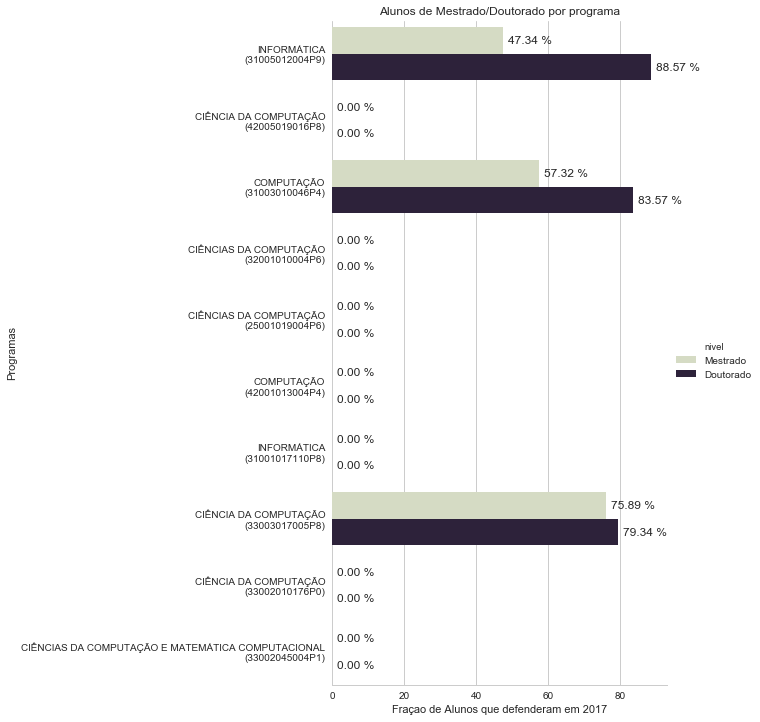

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="fracao_alunos", y="programas", hue="nivel", data=_new_table,
                   size=10, kind="bar", palette=sns.cubehelix_palette(2, start=.5, rot=-.75))

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Fraçao de Alunos que defenderam em 2017")
g.set_ylabels("Programas")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Alunos de Mestrado/Doutorado por programa")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f} %".format( p.get_width(), 2 ),
                (p.get_x() + p.get_width(), p.get_y() + 0.4),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()

### Questão 9

Quantos artigos de periódico/trabalhos em anais foram publicados por cada programa em 2017?

###### Definir DataFrame da Tabela de Produção

In [117]:
import pandas as pd

csv_file = "producao.csv"
producao_raw = pd.read_csv(csv_file)
producao_data = producao_raw
# producao_data.head()

###### Reorganizar tabelas (retirar colunas desnecessárias para a questão)

In [118]:
# Utilizando uma variavel auxiliar para mexer com a tabela
aux_producao_data = producao_data.copy()

necessary_columns = ['subtipo', 'programa', 'ano']

# Manter somente as colunas necessárias na tabela
to_drop_in_producao = []
for column_name in aux_producao_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in necessary_columns): # Selecionar colunas desncessárias
        to_drop_in_producao.append(column_name)

aux_producao_data = aux_producao_data.drop(to_drop_in_producao, 1) # Retirar colunas desnecessárias

In [119]:
# aux_producao_data.head()

###### Definir dados necessários (total de artigos de periodico/trabalhos em anais por programa em 2017)

In [120]:
import array

# Definir quais são todos os diferentes programas
programas = []

for index, row in aux_producao_data.iterrows():
    programa = row['programa']
    if(programa not in programas and isinstance(programa, str)):
        programas.append(programa)
        
# Definir o total de artigos de periodico/trabalhos em anais em cada programa em 2017
periodico_por_programa = array.array('i', (0 for i in range(0, len(programas))))
anais_por_programa = array.array('i', (0 for i in range(0, len(programas))))

for index, row in aux_producao_data.iterrows():
    programa = row['programa']
    subtipo = row['subtipo']
    if(isinstance(programa, str)):
        index = programas.index(programa)
        if(isinstance(subtipo, str)):
            if(subtipo == 'TRABALHO EM ANAIS'):
                anais_por_programa[index] += 1
            elif(subtipo == 'ARTIGO EM PERIÓDICO'):
                periodico_por_programa[index] += 1
            
# Refatorar os nomes dos programas (break lines entre nome do programa e número do programa)
_final_programas = []
        
def treat_x_labels(labels):
    for label in labels:
        index = label.index('(');
        nome_programa = label[:index]
        num_programa = label[index:]
        _final_programas.append(nome_programa + '\n' + num_programa)

treat_x_labels(programas)

###### Agrupar os dados em um DataFrame para a vizualização

In [121]:
# Definir as colunas do data frame
_new_columns = ['programa', 'tipo', 'total_tipo']

# Criar data
_new_data = []

# Adicionar dados a data
for programa in _final_programas:
    index = _final_programas.index(programa)
    _new_data.append([programa, 'Artigo de Periodico', periodico_por_programa[index]])
    _new_data.append([programa, 'Trabalho em Anais', anais_por_programa[index]])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

###### Gráfico para vizualização dos dados

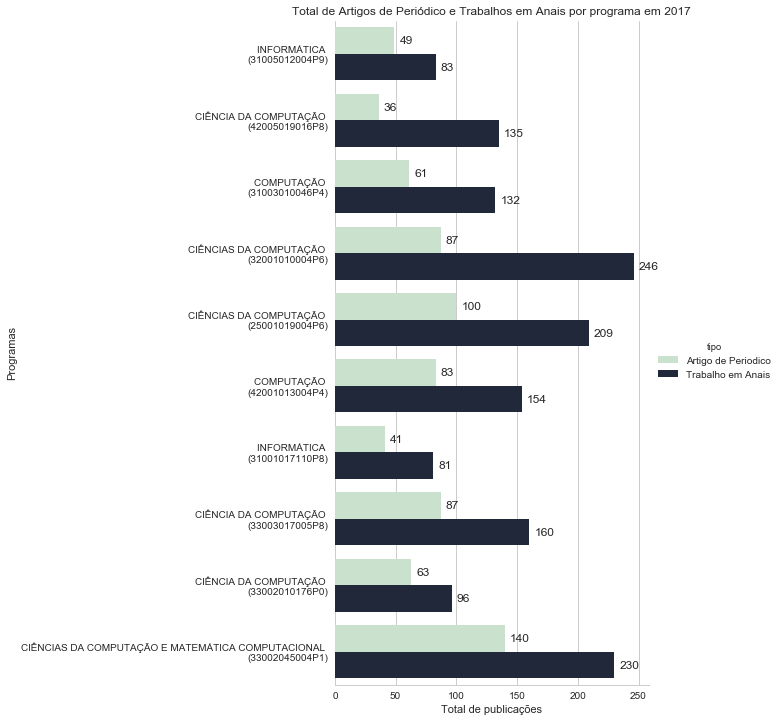

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="total_tipo", y="programa", hue="tipo", data=_new_table,
                   size=10, kind="bar", palette=sns.cubehelix_palette(2, rot=-.4))

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Total de publicações")
g.set_ylabels("Programas")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Total de Artigos de Periódico e Trabalhos em Anais por programa em 2017")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f}".format( p.get_width(), 0 ),
                (p.get_x() + p.get_width(), p.get_y() + 0.4),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()

### Questão 10

Qual é a taxa de artigos de periódico/trabalhos em anais por número de docentes permanentes de cada programa em 2017?

###### Definir DataFrame para Tabela de Docentes

In [108]:
import pandas as pd

csv_file = "docentes.csv"
docentes_raw = pd.read_csv(csv_file)
docentes_data = docentes_raw
# docentes_data.head()

###### Reorganizar tabelas (definir colunas necessárias para a questão)

In [109]:
# Utilizando um variaveis auxiliares para mexer com as tabelas
aux_producao_data = producao_data.copy()
aux_docentes_data = docentes_data.copy()

necessary_columns = ['subtipo', 'programa', 'ano', 'paper_autores', 'ies']

# Manter somente as colunas necessárias na tabela
to_drop_in_producao = []
for column_name in aux_producao_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in necessary_columns): # Selecionar colunas desncessárias
        to_drop_in_producao.append(column_name)

aux_producao_data = aux_producao_data.drop(to_drop_in_producao, 1) # Retirar colunas desnecessárias

In [110]:
# aux_producao_data.head()

In [111]:
# aux_docentes_data.head()

###### Tratar dados para comparação entre tabelas

In [112]:
# Dicionários para guardar strings definitivas (chaves) e as strings equivalentes (valores)
# Ex: PUC-Rio: [PUC-Rio, PUC - RIO, puc rj, puc rio]
possible_ies = {}

# Verificar se as strings sao equivalentes
def match_strings(str1, str2, error):
    diffs = 0
    aux_str1 = str1.replace(" ", "")
    aux_str2 = str2.replace(" ", "")
    for a, b in zip(aux_str1, aux_str2):
        if a != b:
            diffs += 1
            if(diffs > error):
                return 0
    return 1

# Tratar strings: tenta  verificar se a string pertence à algum grupo e adicioná-la à ele, ou criar um novo grupo para ela
def treat_string(c):
    if(not isinstance(c, str)):
        return c
    else:
        possible_group = possible_ies
        error = 10

        # Para cada grupo, verifica se a string stual pertence aquele grupo (igual à uma string daquele grupo)
        for key in possible_group:
            if(c in possible_group[key]):
                return key
                break
            else:
                # Para cada string do grupo, verifica se a string atual é semelhante
                for possible_name in possible_group[key]:
                    if(match_strings(c, possible_name, error)):
                        possible_group[key].append(c);
                        return key
                        break
        # Se a string não se assemelha à nenhum grupo, cria um grupo novo para ela
        possible_group[c] = [c]
        return c
    
def transform_into_list(c):
    if(isinstance(c, str)):
        c = c[2:]
        c = c[:-2]
        c = c.split("', '")
        return c
    
# Aplica o tratamento de strings às tabelas auxiliares
for column in aux_docentes_data:
    if(column == 'ies'):
        aux_docentes_data[column] = aux_docentes_data[column].apply(treat_string)

for column in aux_producao_data:
    if(column == 'paper_autores'):
        aux_producao_data[column] = aux_producao_data[column].apply(transform_into_list)
    if(column == 'ies'):
        aux_producao_data[column] = aux_producao_data[column].apply(treat_string)

###### Definir dados necessários (número de docentes permanentes em cada programa)

In [113]:
# Definir quais são todos os diferentes programas
programas = []

for index, row in aux_producao_data.iterrows():
    programa = row['programa']
    if(programa not in programas and isinstance(programa, str)):
        programas.append(programa)
        
# Separar listas de docentes permanentes por ordem alfabetica
ordem_alfabetica = {}

for index, row in aux_docentes_data.iterrows():
    primeira_letra_nome = row['nome'][:1]
    ies_docente = row['ies']
    categoria = row['categoria']
    if(isinstance(categoria, str) and categoria == 'PERMANENTE'):
        is_in_ordem_alfabetica = 0
        for key in ordem_alfabetica:
            if(key == primeira_letra_nome):
                ordem_alfabetica[key].append([row['nome'], ies_docente])
                is_in_ordem_alfabetica = 1
                break
        if(is_in_ordem_alfabetica == 0):
            ordem_alfabetica[primeira_letra_nome] = [[row['nome'], ies_docente]]

# Definir os docentes permanentes por programa
docentes_por_programa = {}

for programa in programas:
    docentes_por_programa[programa] = []

i = 0
    
for index, row in aux_producao_data.iterrows():
    programa = row['programa']
    autores = row['paper_autores']
    ies = row['ies']
    if(isinstance(programa, str)):
        doc_has_it = 0
        # Para cada autor do artigo/trabalho
        for autor in autores:
            # Verifica se o autor com aquele ies ja esta na lista de docentes_por_programa daquele programa
            for doc_nome, doc_ies in docentes_por_programa[programa]:
                if(autor == doc_nome and ies == doc_ies):
                    doc_has_it = 1
                    break
            # Caso contrário, procura na tabela de docentes pelo autor com aquele ies
            if(doc_has_it == 0):
                primeira_letra_autor = autor[:1]
                try:
                    for ord_nome, ord_ies in ordem_alfabetica[primeira_letra_autor]:
                        if(ord_nome == autor and ord_ies == ies):
                            docentes_por_programa[programa].append([autor, ies])
                            break
                except:
                    # Do nothing
                    i = i
        i += 1

# Definir a fração de alunos de mestrado/doutorado que defenderam em 2017 por programa
_final_periodico_por_programa = []
_final_anais_por_programa = []

for programa in programas:
    index = programas.index(programa)
    _final_periodico_por_programa.append(float(periodico_por_programa[index] / len(docentes_por_programa[programa])))
    _final_anais_por_programa.append(float(anais_por_programa[index] / len(docentes_por_programa[programa])))
         
# Refatorar os nomes dos programas (break lines entre nome do programa e número do programa)
_final_programas = []
        
def treat_x_labels(labels):
    for label in labels:
        index = label.index('(');
        nome_programa = label[:index]
        num_programa = label[index:]
        _final_programas.append(nome_programa + '\n' + num_programa)

treat_x_labels(programas)

###### Agrupar os dados em um DataFrame para a vizualização

In [114]:
# Definir as colunas do data frame
_new_columns = ['programa', 'tipo', 'fracao_tipo']

# Criar data
_new_data = []

# Adicionar dados a data
for programa in _final_programas:
    index = _final_programas.index(programa)
    _new_data.append([programa, 'Artigo de Periodico', _final_periodico_por_programa[index]])
    _new_data.append([programa, 'Trabalho em Anais', _final_anais_por_programa[index]])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

###### Gráfico para a vizualização dos dados

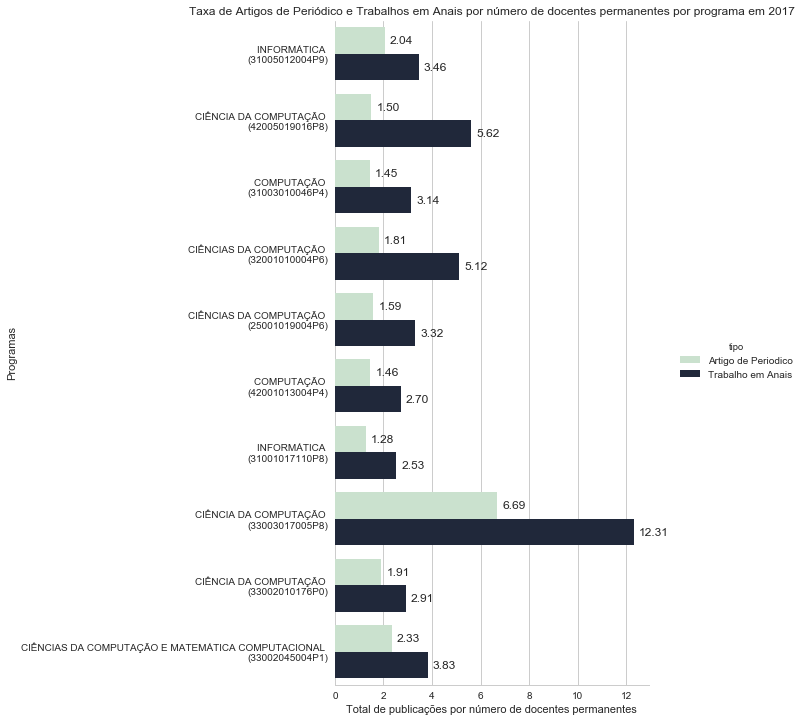

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="fracao_tipo", y="programa", hue="tipo", data=_new_table,
                   size=10, kind="bar", palette=sns.cubehelix_palette(2, rot=-.4))

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Total de publicações por número de docentes permanentes")
g.set_ylabels("Programas")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Taxa de Artigos de Periódico e Trabalhos em Anais por número de docentes permanentes por programa em 2017")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f}".format( p.get_width(), 2 ),
                (p.get_x() + p.get_width(), p.get_y() + 0.4),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()

### Questão 11

Qual fração de artigos de periódico/trabalhos em anais publicados em 2017 teve a coautoria de discentes?

###### Reorganizar tabelas (retirar colunas desnecessárias para a questão)

In [102]:
# Utilizando uma variavel auxiliar para mexer com a tabela
aux_producao_data = producao_data.copy()

necessary_columns = ['subtipo', 'ano', 'num_discentes']

# Manter somente as colunas necessárias na tabela
to_drop_in_producao = []
for column_name in aux_producao_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in necessary_columns): # Selecionar colunas desncessárias
        to_drop_in_producao.append(column_name)

aux_producao_data = aux_producao_data.drop(to_drop_in_producao, 1) # Retirar colunas desnecessárias

In [103]:
# aux_producao_data.head()

###### Definir dados necessários (total de artigos de periodicos/trabalhos em anais com coautoria de discentes em 2017)

In [104]:
import array
        
# Definir o total de artigos de periodico/trabalhos em anais com/sem coautoria de discentes em 2017
periodico_com_coautoria = 0
anais_com_coautoria = 0
total_periodicos = 0
total_anais = 0

for index, row in aux_producao_data.iterrows():
    ano = row['ano']
    subtipo = row['subtipo']
    coautoria = row['num_discentes']
    if(isinstance(ano, float) and ano == 2017):
        if(isinstance(subtipo, str)):
            if(subtipo == 'TRABALHO EM ANAIS'):
                total_anais += 1
                if(isinstance(coautoria, int) and coautoria > 0):
                    anais_com_coautoria += 1
            elif(subtipo == 'ARTIGO EM PERIÓDICO'):
                total_periodicos +=1
                if(isinstance(coautoria, int) and coautoria > 0):
                    periodico_com_coautoria += 1
                    
_final_periodico_com_coautoria = (float) (periodico_com_coautoria / total_periodicos * 100)
_final_anais_com_coautoria = (float) (anais_com_coautoria / total_anais * 100)

###### Agrupar os dados em um DataFrame para a vizualização

In [105]:
# Definir as colunas do data frame
_new_columns = ['tipo', 'coautoria']

# Criar data
_new_data = []

# Adicionar dados a data
_new_data.append(['Artigo de Periodico', _final_periodico_com_coautoria])
_new_data.append(['Trabalho em Anais', _final_anais_com_coautoria])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

###### Gráfico para vizualização dos dados

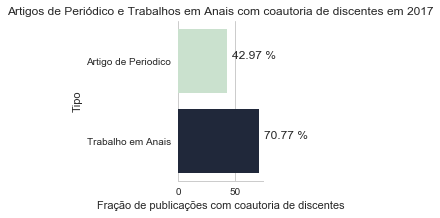

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="coautoria", y="tipo", data=_new_table,
                   size=3, kind="bar", palette=sns.cubehelix_palette(2, rot=-.4))

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Fração de publicações com coautoria de discentes")
g.set_ylabels("Tipo")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Artigos de Periódico e Trabalhos em Anais com coautoria de discentes em 2017")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f} %".format( p.get_width(), 2 ),
                (p.get_x() + p.get_width(), p.get_y() + 0.5),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()

### Questão 12

Qual fração de artigos de periódico/trabalhos em anais publicados em 2017 teve a coautoria de participantes externos?

###### Reorganizar tabelas (retirar colunas desnecessárias para a questão)

In [97]:
# Utilizando uma variavel auxiliar para mexer com a tabela
aux_producao_data = producao_data.copy()

necessary_columns = ['subtipo', 'ano', 'num_externos']

# Manter somente as colunas necessárias na tabela
to_drop_in_producao = []
for column_name in aux_producao_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in necessary_columns): # Selecionar colunas desncessárias
        to_drop_in_producao.append(column_name)

aux_producao_data = aux_producao_data.drop(to_drop_in_producao, 1) # Retirar colunas desnecessárias

In [98]:
# aux_producao_data.head()

###### Definir dados necessários (total de artigos de periodicos/trabalhos em anais com coautoria de externos em 2017)

In [99]:
import array
        
# Definir o total de artigos de periodico/trabalhos em anais com/sem coautoria de discentes em 2017
periodico_com_coautoria = 0
anais_com_coautoria = 0
total_periodicos = 0
total_anais = 0

for index, row in aux_producao_data.iterrows():
    ano = row['ano']
    subtipo = row['subtipo']
    coautoria = row['num_externos']
    if(isinstance(ano, float) and ano == 2017):
        if(isinstance(subtipo, str)):
            if(subtipo == 'TRABALHO EM ANAIS'):
                total_anais += 1
                if(isinstance(coautoria, int) and coautoria > 0):
                    anais_com_coautoria += 1
            elif(subtipo == 'ARTIGO EM PERIÓDICO'):
                total_periodicos +=1
                if(isinstance(coautoria, int) and coautoria > 0):
                    periodico_com_coautoria += 1
                    
_final_periodico_com_coautoria = (float) (periodico_com_coautoria / total_periodicos * 100)
_final_anais_com_coautoria = (float) (anais_com_coautoria / total_anais * 100)

###### Agrupar os dados em um DataFrame para a vizualização

In [100]:
# Definir as colunas do data frame
_new_columns = ['tipo', 'coautoria']

# Criar data
_new_data = []

# Adicionar dados a data
_new_data.append(['Artigo de Periodico', _final_periodico_com_coautoria])
_new_data.append(['Trabalho em Anais', _final_anais_com_coautoria])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

###### Gráfico para vizualização dos dados

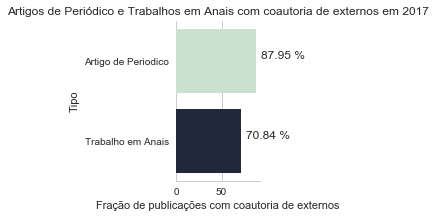

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="coautoria", y="tipo", data=_new_table,
                   size=3, kind="bar", palette=sns.cubehelix_palette(2, rot=-.4))

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Fração de publicações com coautoria de externos")
g.set_ylabels("Tipo")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Artigos de Periódico e Trabalhos em Anais com coautoria de externos em 2017")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f} %".format( p.get_width(), 2 ),
                (p.get_x() + p.get_width(), p.get_y() + 0.5),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()

### Questão 13

Qual é a distribuição de artigos de periódico publicados em 2017, por estrato do Qualis?

###### Definir DataFrame da Tabela da Qualis

In [123]:
import pandas as pd

excel_file = "Qualis CC 2013-2016.xlsx"
qualis_raw = pd.read_excel(excel_file)
qualis_data = qualis_raw
qualis_data.rename(columns = {'ISSN': 'issn', 'Título': 'periodico', 'Estrato': 'estrato'}, inplace=True)
# qualis_data.head()

###### Reorganizar tabelas (retirar colunas desnecessárias)

In [124]:
# Utilizando uma variavel auxiliar para mexer com a tabela
aux_producao_data = producao_data.copy()

necessary_columns = ['periodico', 'ano', 'subtipo', 'issn']

# Manter somente as colunas necessárias na tabela
to_drop_in_producao = []
for column_name in aux_producao_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in necessary_columns): # Selecionar colunas desncessárias
        to_drop_in_producao.append(column_name)

aux_producao_data = aux_producao_data.drop(to_drop_in_producao, 1) # Retirar colunas desnecessárias

In [125]:
# aux_producao_data.head()

###### Preparação de Dados para RIGHT JOIN

In [126]:
# Tratar strings: tenta  verificar se a string pertence à algum grupo e adicioná-la à ele, ou criar um novo grupo para ela
def remove_issn(c):
    if(not isinstance(c, str)):
        return c
    else:
        nome_periodico = c[12:]
        return nome_periodico
    
# Aplica o tratamento de strings às tabelas auxiliares
for column in aux_producao_data:
    if(column == 'periodico'):
        aux_producao_data[column] = aux_producao_data[column].apply(remove_issn)

In [127]:
# aux_producao_data.head()

###### RIGHT JOIN das tabelas

In [128]:
# Mergeando as tabelas

merged_qualis_producao = pd.merge(qualis_data, aux_producao_data, how='right', on=['issn', 'periodico'])
# merged_qualis_producao.head()

###### Definir dados necessários (total de artigos de periodicos publicados em 2017 por estrato da Qualis)

In [129]:
import array
        
# Definir quais são todos os diferentes estratos
estratos = []

for index, row in qualis_data.iterrows():
    estrato = row['estrato']
    if(estrato not in estratos and isinstance(estrato, str)):
        estratos.append(estrato)

# Definir o total de artigos de periodico/trabalhos em anais com/sem coautoria de discentes em 2017
periodico_por_extrato = array.array('i', (0 for i in range(0, len(estratos))))

for index, row in merged_qualis_producao.iterrows():
    ano = row['ano']
    subtipo = row['subtipo']
    estrato = row['estrato']
    if(isinstance(ano, float) and ano == 2017):
        if(isinstance(subtipo, str)):
            if(subtipo == 'ARTIGO EM PERIÓDICO'):
                if(isinstance(estrato, str)):
                    index = estratos.index(estrato)
                    periodico_por_extrato[index] += 1

###### Agrupar os dados em um DataFrame para a vizualização

In [130]:
# Definir as colunas do data frame
_new_columns = ['estrato', 'total_periodicos']

# Criar data
_new_data = []

# Adicionar dados a data
for estrato in estratos:
    index = estratos.index(estrato)
    _new_data.append([estrato, periodico_por_extrato[index]])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

###### Gráfico para vizualização dos dados

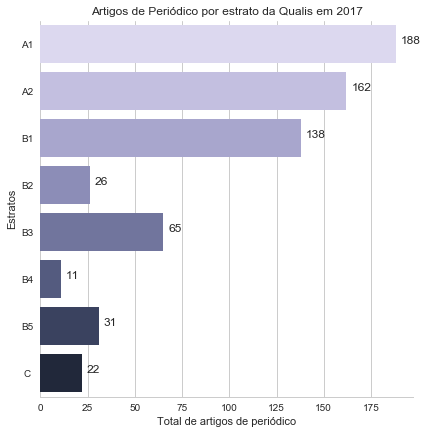

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="total_periodicos", y="estrato", data=_new_table,
                   size=6, kind="bar", palette=sns.cubehelix_palette(8, start=2.8, rot=.1))

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Total de artigos de periódico")
g.set_ylabels("Estratos")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Artigos de Periódico por estrato da Qualis em 2017")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f}".format( p.get_width(), 0),
                (p.get_x() + p.get_width(), p.get_y() + 0.6),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()

### Questão 14

Considerando os pesos dos artigos de cada estrato do índice restrito ({'A1': 1, 'A2': 0.85, 'B1': 0.70}), qual o índice restrito relativo de cada programa, considerando apenas os artigos em periódicos, e dividido pelo número de docentes permanentes (ordenado do maior para o menor)?

###### Reorganizar tabelas (retirar colunas desncessárias)

In [77]:
# Utilizando uma variavel auxiliar para mexer com a tabela
aux_producao_data = producao_data.copy()

necessary_columns = ['periodico', 'programa', 'subtipo', 'issn']

# Manter somente as colunas necessárias na tabela
to_drop_in_producao = []
for column_name in aux_producao_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in necessary_columns): # Selecionar colunas desncessárias
        to_drop_in_producao.append(column_name)

aux_producao_data = aux_producao_data.drop(to_drop_in_producao, 1) # Retirar colunas desnecessárias

In [78]:
# aux_producao_data.head()

###### Preparação de dados para RIGHT JOIN

In [79]:
# Tratar strings: tenta  verificar se a string pertence à algum grupo e adicioná-la à ele, ou criar um novo grupo para ela
def remove_issn(c):
    if(not isinstance(c, str)):
        return c
    else:
        nome_periodico = c[12:]
        return nome_periodico
    
# Aplica o tratamento de strings às tabelas auxiliares
for column in aux_producao_data:
    if(column == 'periodico'):
        aux_producao_data[column] = aux_producao_data[column].apply(remove_issn)

In [80]:
# aux_producao_data.head()

###### RIGHT JOIN

In [81]:
# Mergeando as tabelas

merged_qualis_producao = pd.merge(qualis_data, aux_producao_data, how='right', on=['issn', 'periodico'])
# merged_qualis_producao.head()

###### Definir dados necessários (total de artigos de periódico de cada estrato do índice restrito por programa)

In [82]:
import array

# Definir indice restrito
indice_restrito = ['A1', 'A2', 'B1']
valores_indice_restrito = {'A1': 1, 'A2': 0.85, 'B1': 0.70}
        
# Definir quais são todos os diferentes programas
programas = []

for index, row in aux_producao_data.iterrows():
    programa = row['programa']
    if(programa not in programas and isinstance(programa, str)):
        programas.append(programa)

# Definir o total de artigos de periodico de cada estrato do índice restrito por programa
periodico_por_extrato_por_programa = {}
for programa in programas:
    periodico_por_extrato_por_programa[programa] = {}
    for indice in indice_restrito:
        periodico_por_extrato_por_programa[programa][indice] = 0
        
for index, row in merged_qualis_producao.iterrows():
    programa = row['programa']
    subtipo = row['subtipo']
    estrato = row['estrato']
    if(isinstance(programa, str)):
        if(isinstance(subtipo, str)):
            if(subtipo == 'ARTIGO EM PERIÓDICO'): # Se é um artigo em periódico
                if(estrato in indice_restrito): # Se o estrato pertence ao índice restrito
                    periodico_por_extrato_por_programa[programa][estrato] += 1 # Adiciona um artigo àquele programa pelo índice
                    
# Definir a fração de alunos de mestrado/doutorado que defenderam em 2017 por programa
_final_periodico_por_extrato_por_programa = {}

for programa in programas:
    indice_relativo_programa = 0
#     total_de_artigos_no_programa = 0
    for indice in indice_restrito:
        total_de_artigos_no_indice = periodico_por_extrato_por_programa[programa][indice]
        indice_relativo_programa += total_de_artigos_no_indice * valores_indice_restrito[indice]
#         total_de_artigos_no_programa += total_de_artigos_no_indice
#     indice_relativo_programa = indice_relativo_programa / total_de_artigos_no_programa
    value = float(indice_relativo_programa / len(docentes_por_programa[programa]))
    index = programas.index(programa)
    _final_periodico_por_extrato_por_programa[index] = value
         
# Refatorar os nomes dos programas (break lines entre nome do programa e número do programa)
_final_programas = []
        
def treat_x_labels(labels):
    for label in labels:
        index = label.index('(');
        nome_programa = label[:index]
        num_programa = label[index:]
        _final_programas.append(nome_programa + '\n' + num_programa)

treat_x_labels(programas)

In [83]:
# _final_periodico_por_extrato_por_programa

###### Agrupando os dados em um DataFrame para vizualização

In [84]:
# Definir as colunas do data frame
_new_columns = ['programa', 'fracao_indice_docentes']

# Criar data
_new_data = []

# Adicionar dados a data
for programa in _final_programas:
    index = _final_programas.index(programa)
    _new_data.append([programa, _final_periodico_por_extrato_por_programa[index]])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

_new_table = _new_table.sort_values('fracao_indice_docentes', ascending=False)

###### Gráfico para vizualização dos dados

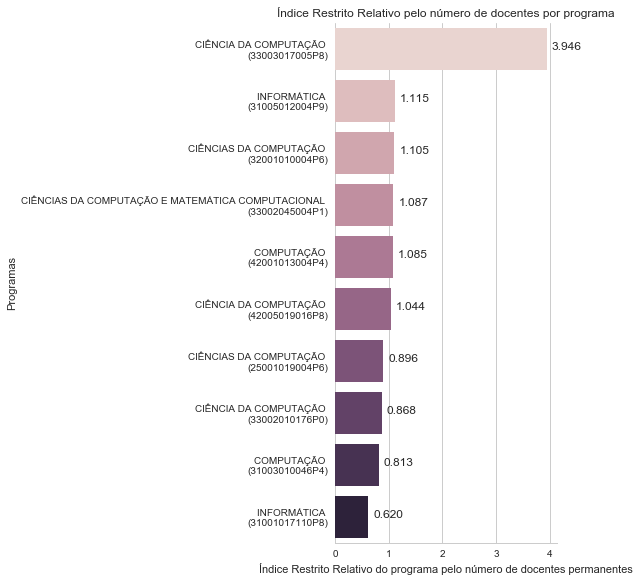

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="fracao_indice_docentes", y="programa", data=_new_table,
                   size=8, kind="bar", palette=sns.cubehelix_palette(10))

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Índice Restrito Relativo do programa pelo número de docentes permanentes")
g.set_ylabels("Programas")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Índice Restrito Relativo pelo número de docentes por programa")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f}".format( p.get_width(), 3),
                (p.get_x() + p.get_width(), p.get_y() + 0.6),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()

### Questão 15

Considerando os pesos dos artigos de cada estrato do índice geral ({'A1': 1, 'A2': 0.85, 'B1': 0.70, 'B2': 0.50, 'B3': 0.20, 'B4': 0.10, 'B5': 0.05, 'C': 0.0}), qual o índice geral relativo de cada programa, considerando apenas os artigos em periódicos, e dividido pelo número de docentes permanentes (ordenado do maior para o menor)?

###### Reorganizar tabelas (retirar colunas desnecessárias)

In [226]:
# Utilizando uma variavel auxiliar para mexer com a tabela
aux_producao_data = producao_data.copy()

necessary_columns = ['periodico', 'programa', 'subtipo', 'issn']

# Manter somente as colunas necessárias na tabela
to_drop_in_producao = []
for column_name in aux_producao_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in necessary_columns): # Selecionar colunas desncessárias
        to_drop_in_producao.append(column_name)

aux_producao_data = aux_producao_data.drop(to_drop_in_producao, 1) # Retirar colunas desnecessárias

###### Preparação de dados para RIGHT JOIN

In [227]:
# Tratar strings: tenta  verificar se a string pertence à algum grupo e adicioná-la à ele, ou criar um novo grupo para ela
def remove_issn(c):
    if(not isinstance(c, str)):
        return c
    else:
        nome_periodico = c[12:]
        return nome_periodico
    
# Aplica o tratamento de strings às tabelas auxiliares
for column in aux_producao_data:
    if(column == 'periodico'):
        aux_producao_data[column] = aux_producao_data[column].apply(remove_issn)

###### RIGHT JOIN

In [228]:
# Mergeando as tabelas

merged_qualis_producao = pd.merge(qualis_data, aux_producao_data, how='right', on=['issn', 'periodico'])
# merged_qualis_producao.head()

###### Definir dados necessários (total de artigos de periódico de cada estrato do índice restrito por programa)

In [54]:
import array

# Definir indice restrito
indice_geral = ['A1', 'A2', 'B1', 'B2', 'B3', 'B4', 'B5', 'C']
valores_indice_geral = {'A1': 1, 'A2': 0.85, 'B1': 0.70, 'B2': 0.50, 'B3': 0.20, 'B4': 0.10, 'B5': 0.05, 'C': 0.0}
        
# Definir quais são todos os diferentes programas
programas = []

for index, row in aux_producao_data.iterrows():
    programa = row['programa']
    if(programa not in programas and isinstance(programa, str)):
        programas.append(programa)

# Definir o total de artigos de periodico de cada estrato do índice restrito por programa
periodico_por_extrato_por_programa = {}
for programa in programas:
    periodico_por_extrato_por_programa[programa] = {}
    for indice in indice_geral:
        periodico_por_extrato_por_programa[programa][indice] = 0
        
for index, row in merged_qualis_producao.iterrows():
    programa = row['programa']
    subtipo = row['subtipo']
    estrato = row['estrato']
    if(isinstance(programa, str)):
        if(isinstance(subtipo, str)):
            if(subtipo == 'ARTIGO EM PERIÓDICO'): # Se é um artigo em periódico
                if(estrato in indice_geral): # Se o estrato pertence ao índice restrito
                    periodico_por_extrato_por_programa[programa][estrato] += 1 # Adiciona um artigo àquele programa pelo índice
                    
# Definir a fração de alunos de mestrado/doutorado que defenderam em 2017 por programa
_final_periodico_por_extrato_por_programa = {}

for programa in programas:
    indice_relativo_programa = 0
#     total_de_artigos_no_programa = 0
    for indice in indice_geral:
        total_de_artigos_no_indice = periodico_por_extrato_por_programa[programa][indice]
        indice_relativo_programa += total_de_artigos_no_indice * valores_indice_geral[indice]
#         total_de_artigos_no_programa += total_de_artigos_no_indice
#     indice_relativo_programa = indice_relativo_programa / total_de_artigos_no_programa
    value = float(indice_relativo_programa / len(docentes_por_programa[programa]))
    index = programas.index(programa)
    _final_periodico_por_extrato_por_programa[index] = value
         
# Refatorar os nomes dos programas (break lines entre nome do programa e número do programa)
_final_programas = []
        
def treat_x_labels(labels):
    for label in labels:
        index = label.index('(');
        nome_programa = label[:index]
        num_programa = label[index:]
        _final_programas.append(nome_programa + '\n' + num_programa)

treat_x_labels(programas)

###### Agrupando os dados em um DataFrame para vizualização

In [55]:
# Definir as colunas do data frame
_new_columns = ['programa', 'fracao_indice_docentes']

# Criar data
_new_data = []

# Adicionar dados a data
for programa in _final_programas:
    index = _final_programas.index(programa)
    _new_data.append([programa, _final_periodico_por_extrato_por_programa[index]])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

_new_table = _new_table.sort_values('fracao_indice_docentes', ascending=False)

###### Gráfico para vizualização dos dados

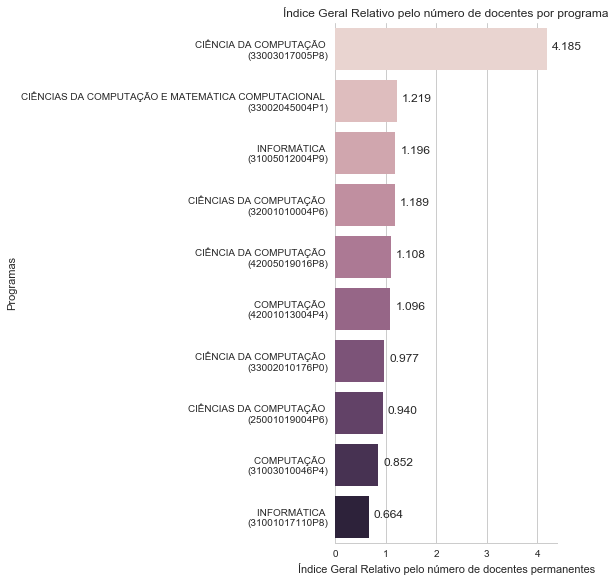

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="fracao_indice_docentes", y="programa", data=_new_table,
                   size=8, kind="bar", palette=sns.cubehelix_palette(10))

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Índice Geral Relativo pelo número de docentes permanentes")
g.set_ylabels("Programas")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Índice Geral Relativo pelo número de docentes por programa")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f}".format( p.get_width(), 3),
                (p.get_x() + p.get_width(), p.get_y() + 0.6),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()